In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from xgboost import XGBRegressor
from tensorflow import keras
from scipy.interpolate import interpn
from tqdm import tqdm

In [2]:
from load_data import process_steel_data

full_path = 'data/'
path = 'data/MDC_Data_Descriptions_MeCoMeP-r-value.xlsx'
correlation_rate = 0.2
dvl_line = 1

df = process_steel_data(full_path, path, correlation_rate, dvl_line, model_output=False)
df = pd.get_dummies(df, columns=['steel_family'], prefix='steel').drop(['steel_grade'], axis=1)

c:\Users\A070050\AppData\Local\Programs\Python\Python38\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


Dropped 25 columns


In [3]:
from sklearn.preprocessing import StandardScaler

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Identify binary columns (one-hot encoded)
binary_columns = [col for col in df.columns if col.startswith('steel_')]

# Identify columns to scale (non-binary columns)
columns_to_scale = [col for col in df.columns if col not in binary_columns + ['steel_grade']]

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df[columns_to_scale])
test_scaled = scaler.transform(test_df[columns_to_scale])

train_scaled_df = pd.DataFrame(train_scaled, columns=columns_to_scale)
test_scaled_df = pd.DataFrame(test_scaled, columns=columns_to_scale)

for col in binary_columns:
    train_scaled_df[col] = train_df[col].values
    test_scaled_df[col] = test_df[col].values

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

def optimize_hyperparameters_rfr(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 150, 200, 350, 300],
    }
    grid_search = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_
    }

def train_optimized_model(df, model_type):

    X = df.drop(['r_value'] if 'steel_grade' in df.columns else ['r_value'], axis=1)
    y = df['r_value']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model based on type
    if model_type == 'rfr':
        optimization_results = optimize_hyperparameters_rfr(X_train, y_train)
    elif model_type == 'xgb':
        optimization_results = optimize_hyperparameters_xgb(X_train, y_train)
    elif model_type == 'gpr':
        optimization_results = optimize_hyperparameters_gpr(X_train, y_train)
    elif model_type == 'knn':
        optimization_results = optimize_hyperparameters_knn(X_train, y_train)
    elif model_type == 'svr':
        optimization_results = optimize_hyperparameters_svr(X_train, y_train)
    elif model_type == 'ridge':
        optimization_results = optimize_hyperparameters_ridge(X_train, y_train)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    # Get best model and make predictions
    best_model = optimization_results['best_estimator']
    best_model.fit(X_train, y_train)
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
      
    results = {
        'model': best_model,
        'best_params': optimization_results['best_params'],
        'best_score': optimization_results['best_score'],
        'train_mse': mean_squared_error(y_train, y_pred_train),
        'val_mse': mean_squared_error(y_test, y_pred_test),
        'train_mae': mean_absolute_error(y_train, y_pred_train),
        'val_mae': mean_absolute_error(y_test, y_pred_test),
        'train_r2': r2_score(y_train, y_pred_train),
        'val_r2': r2_score(y_test, y_pred_test)
    }
    
    return results

In [5]:
# Run optimization
model_info = train_optimized_model(train_scaled_df, model_type='rfr')

print(f"Best Parameters: {model_info['best_params']}")
print(f"Best CV Score (MSE): {model_info['best_score']}")
print(f"VAL MAE: {model_info['val_mae']}")
print(f"VAL R2: {model_info['val_r2']}")

Best Parameters: {'n_estimators': 350}
Best CV Score (MSE): 0.1687231027394549
VAL MAE: 0.16575364298489617
VAL R2: 0.9433398744176332


In [6]:
model_info

{'model': RandomForestRegressor(n_estimators=350, random_state=42),
 'best_params': {'n_estimators': 350},
 'best_score': 0.1687231027394549,
 'train_mse': 0.007602882929843038,
 'val_mse': 0.05574431312843727,
 'train_mae': 0.061133943857440844,
 'val_mae': 0.16575364298489617,
 'train_r2': 0.9924267764754128,
 'val_r2': 0.9433398744176332}

In [7]:
def tol90(y_true, y_pred):
    errors = np.abs(y_true - y_pred)
    return np.percentile(errors, 90)

def plot_predicted_vs_actual(models, test_df, is_family_based=False):

    if is_family_based:
        plt.figure(figsize=(15, 5 * len(models)))
        for i, (family, model_info) in enumerate(models.items(), 1):
            plt.subplot(len(models), 1, i)
            
            # Get family specific data
            family_data = test_df[test_df['steel_family'] == family]
            X_test = family_data.drop(['steel_family', 'r_value'], axis=1)
            y_test = family_data['r_value']
            
            # Predict
            y_pred = model_info['model'].predict(X_test)
            
            # Calculate metrics
            r2 = r2_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            tol90_value = tol90(y_test, y_pred)
            
            # Plot
            plot_single_comparison(y_test, y_pred, family, r2, mse, mae, tol90_value)
            
    else:
        plt.figure(figsize=(10, 8))
        X_test = test_df.drop(['r_value'], axis=1)
        y_test = test_df['r_value']
        
        # For single model case
        y_pred = models['model'].predict(X_test)
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        tol90_value = tol90(y_test, y_pred)
        
        # Plot
        plot_single_comparison(y_test, y_pred, "All Families", r2, mse, mae, tol90_value)
    
    plt.tight_layout()
    plt.show()

def plot_single_comparison(y_test, y_pred, title, r2, mse, mae, tol90_value):
    
    # Create density-based scatter plot
    density_scatter(y_test, y_pred, alpha=0.6)
    
    # Plot perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Plot tolerance lines
    plt.plot([min_val, max_val], [min_val + tol90_value, max_val + tol90_value], 
            'g--', lw=1.5, label=f'+tol90 ({tol90_value:.4f})')
    plt.plot([min_val, max_val], [min_val - tol90_value, max_val - tol90_value], 
            'b--', lw=1.5, label=f'-tol90 ({tol90_value:.4f})')
    
    # Annotate with metrics
    plt.text(0.05, 0.95,
            f"Test R²: {r2:.4f}\n" +
            f"Test MSE: {mse:.4f}\n" +
            f"Test MAE: {mae:.4f}\n" +
            f"Test tol90: {tol90_value:.4f}",
            transform=plt.gca().transAxes,
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.8))
    
    plt.title('Predicted vs Actual R-Value')
    plt.xlabel('Actual R-Value')
    plt.ylabel('Predicted R-Value')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

def density_scatter(x, y, bins=30, **kwargs):
    """Create a density scatter plot"""
    data, x_e, y_e = np.histogram2d(x, y, bins=bins)
    z = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:] + y_e[:-1])),
                data.T/data.max(),
                np.vstack([x,y]).T,
                method="splinef2d",
                bounds_error=False)
    z[np.where(np.isnan(z))] = 0.0
    
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    plt.scatter(x, y, c=z, **kwargs)

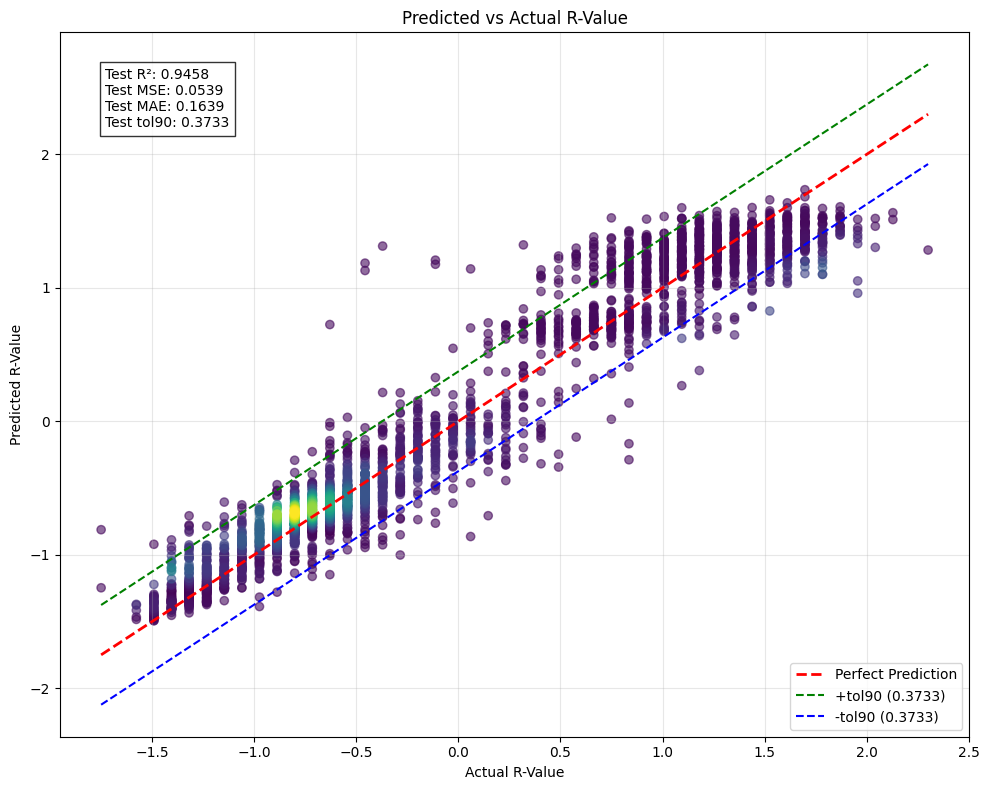

In [8]:
plot_predicted_vs_actual(model_info, test_scaled_df, is_family_based=False)

XGB -----

In [9]:
def optimize_hyperparameters_xgb(X_train, y_train):

    param_grid = {
        'eta': [0.01, 0.1, 0.3],
        'lambda': [0, 0.1, 1, 10],
        'max_depth': [3, 4, 5, 6]
    }
    
    grid_search = GridSearchCV(
        estimator=XGBRegressor(random_state=42),
        param_grid=param_grid,
        cv=5,  # 5-fold cross-validation
        scoring='neg_mean_absolute_error',
        n_jobs=-1  # Use all available cores
    )
    
    grid_search.fit(X_train, y_train)
    
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_
    }

In [10]:
trained_models_xgb = train_optimized_model(train_scaled_df, model_type='xgb')

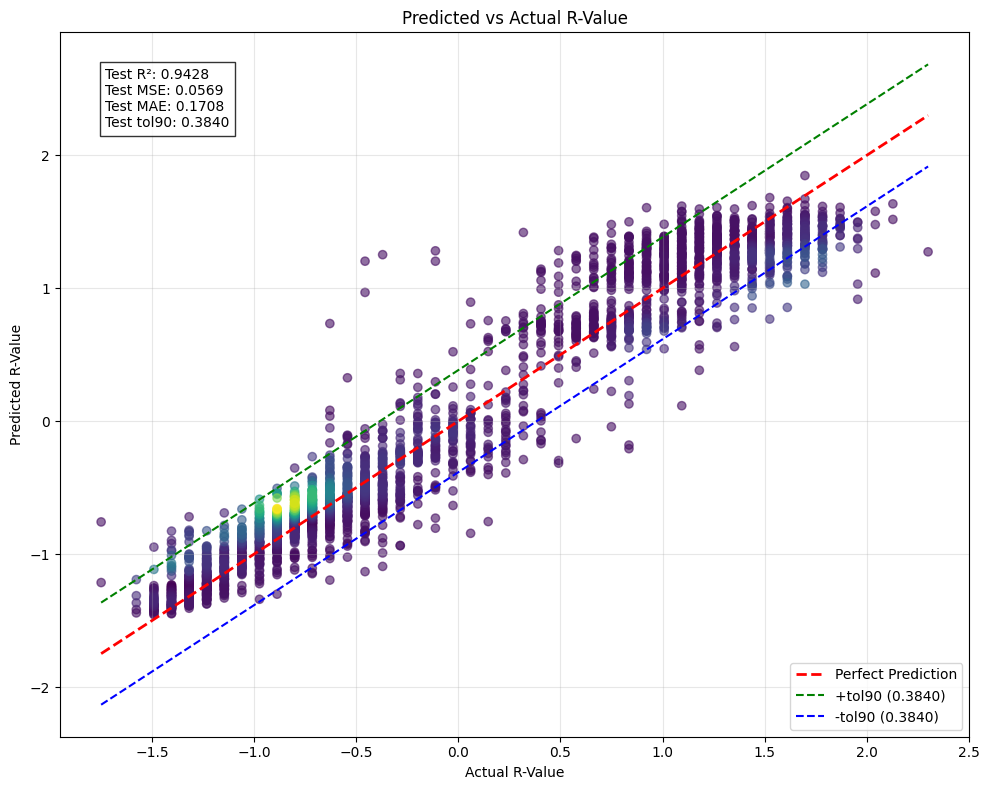

In [11]:
plot_predicted_vs_actual(trained_models_xgb, test_scaled_df)

ANN---- (from Millner paper)

In [12]:
class SteelPropertiesANN:
    def __init__(self, input_dim, target_column):
        self.input_dim = input_dim
        self.target_column = target_column
        self.best_model = None
        self.best_params = None
        self.best_score = float('inf')

    def build_model(self, config):
        hidden_layers = config['layers']
        learning_rate = config['learning_rate']
        l2_strength = config['l2_regularization']
        
        model = keras.Sequential()
        model.add(keras.layers.Input(shape=(self.input_dim,)))
        
        for units, activation in hidden_layers:
            model.add(keras.layers.Dense(
                units=units,
                activation=activation,
                kernel_regularizer=keras.regularizers.l2(l2_strength)
            ))
        
        model.add(keras.layers.Dense(1))
        
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=100,
            decay_rate=0.9,
            staircase=True
        )
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0),
            loss='mean_absolute_error',
            metrics=['mae', 'mse']
        )
        return model

    def generate_grid_configs(self, 
        layer_options=[(64, 'relu'), (128, 'relu'), (256, 'relu')],
        layer_depths=[2, 3, 4],
        learning_rates=[1e-2, 1e-3, 1e-4],
        l2_regularization=[1e-3, 1e-4, 1e-5],
        batch_sizes=[16, 32, 64]
    ):
        from itertools import product
        grid_configs = []
        
        for depth in layer_depths:
            for lr in learning_rates:
                for l2_reg in l2_regularization:
                    for batch_size in batch_sizes:
                        layer_combinations = list(product(layer_options, repeat=depth))
                        for layers in layer_combinations:
                            config = {
                                'layers': layers,
                                'learning_rate': lr,
                                'l2_regularization': l2_reg,
                                'batch_size': batch_size
                            }
                            grid_configs.append(config)
        
        return grid_configs

    def grid_search(self, train_scaled_df, grid_configs=None, epochs=100, max_configs=None):
        # Split training data into training and validation sets
        train_data, val_data = train_test_split(train_scaled_df, test_size=0.2, random_state=42)
    
        if grid_configs is None:
            grid_configs = self.generate_grid_configs()
        
        X_train = train_data.drop([self.target_column], axis=1)
        y_train = train_data[self.target_column]
        X_val = val_data.drop([self.target_column], axis=1)
        y_val = val_data[self.target_column]
        
        if max_configs:
            grid_configs = grid_configs[:max_configs]
        
        results = []
        for config in tqdm(grid_configs, desc="Training models"):
            tf.keras.backend.clear_session()
            model = self.build_model(config)
            batch_size = min(config['batch_size'], len(X_train))
            
            early_stopping = keras.callbacks.EarlyStopping(
                monitor='val_loss', 
                patience=10, 
                restore_best_weights=True,
                min_delta=1e-4
            )
            
            try:
                X_train = np.array(X_train, dtype=np.float32)
                y_train = np.array(y_train, dtype=np.float32)
                X_val = np.array(X_val, dtype=np.float32)
                y_val = np.array(y_val, dtype=np.float32)

                train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
                train_dataset = (train_dataset
                    .batch(batch_size, drop_remainder=True)
                    .repeat())
                
                val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
                val_dataset = val_dataset.batch(batch_size)
                
                steps_per_epoch = len(X_train) // batch_size
                
                history = model.fit(
                    train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[early_stopping],
                    verbose=0
                )
                
                val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
                
                result_entry = config.copy()
                result_entry.update({'val_loss': val_loss})
                results.append(result_entry)
                
                if val_loss < self.best_score:
                    self.best_score = val_loss
                    self.best_model = model
                    self.best_params = config
                
            except Exception as e:
                print(f"Error with config {config}: {str(e)}")
                continue
        
        return self.best_model, self.best_params

    def evaluate(self, test_scaled_df):
        if self.best_model is None:
            raise ValueError("No model has been trained. Call grid_search first.")
        
        X_test = test_scaled_df.drop([self.target_column], axis=1)
        y_test = test_scaled_df[self.target_column]
        
        y_pred = self.best_model.predict(X_test).flatten()
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        tol90_value = tol90(y_test, y_pred)
        
        # Create visualization
        plt.figure(figsize=(10, 8))
        plot_single_comparison(y_test, y_pred, "All Families", r2, mse, mae, tol90_value)
        plt.tight_layout()
        plt.show()
        
        return {
            'model': self.best_model,
            'MSE': mse,
            'MAE': mae,
            'R2': r2,
            'tol90': tol90_value,
            'Best Parameters': self.best_params
        }

In [13]:
# Create the ANN instance
ann = SteelPropertiesANN(
    input_dim=train_scaled_df.drop(['r_value'], axis=1).shape[1],
    target_column='r_value'
)

configs = ann.generate_grid_configs(
    layer_options=[(64, 'relu'), (128, 'relu'), (256, 'relu')],
    layer_depths=[2, 3, 4],
    learning_rates=[1e-3, 1e-4],
    l2_regularization=[1e-3, 1e-4],
    batch_sizes=[16, 32, 64]
)

best_model, best_params = ann.grid_search(train_scaled_df, grid_configs=configs)

# Evaluate and visualize
metrics = ann.evaluate(test_scaled_df)
print("Best Model Metrics:")
print(metrics)

Training models: 100%|██████████| 1404/1404 [7:13:32<00:00, 18.53s/it]  


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [16]:
best_model.save('model.h5')

c:\Users\A070050\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
best_params = {'layers': ((256, 'relu'), (64, 'relu')),
 'learning_rate': 0.001,
 'l2_regularization': 0.0001,
 'batch_size': 64}

{'layers': ((256, 'relu'), (64, 'relu')),
 'learning_rate': 0.001,
 'l2_regularization': 0.0001,
 'batch_size': 64}

In [ ]:
def plot_actual_vs_predicted_ann(y_true, y_pred):
    """
    Plot Actual vs. Predicted values with perfect prediction line and tolerance lines.

    :param y_true: Array of true values
    :param y_pred: Array of predicted values
    """
    # Calculate metrics
    tol90_value = np.percentile(np.abs(y_true - y_pred), 90)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    # Define plot limits
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    
    # Create the scatter plot
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.6, label='Predicted Values')
    
    # Plot perfect prediction line
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Plot tolerance lines
    plt.plot([min_val, max_val], [min_val + tol90_value, max_val + tol90_value], 'g--', lw=1.5, label=f'+tol90 ({tol90_value:.4f})')
    plt.plot([min_val, max_val], [min_val - tol90_value, max_val - tol90_value], 'b--', lw=1.5, label=f'-tol90 ({tol90_value:.4f})')
    
    # Title and labels
    plt.title("Actual vs Predicted Values")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    
    # Annotate with metrics
    plt.text(0.05, 0.95, 
             f"R²: {r2:.4f}\nMSE: {mae:.4f}\ntol90: {tol90_value:.4f}", 
             transform=plt.gca().transAxes, 
             verticalalignment='top')
    
    # Add legend
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


In [ ]:
y_pred = ann.best_model.predict(test_scaled_df.drop(['steel_family', 'r_value'], axis=1)).flatten()
plot_actual_vs_predicted_ann(test_scaled_df['r_value'], y_pred)

GPR ------

In [ ]:
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

def optimize_hyperparameters_gpr(X_train, y_train):

    
    # Define the parameter grid
    param_grid = {
        'kernel': [
            ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-2, 1e2)) * 
            Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5) + 
            WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e1))
        ]
    }
    
    gpr = GaussianProcessRegressor(normalize_y=True)
    
    # Grid search for the best hyperparameters
    grid_search = GridSearchCV(
        estimator=gpr,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_
    }


In [ ]:
trained_models_gpr = train_optimized_family_models(train_scaled_df, model='gpr')

In [ ]:
plot_predicted_vs_actual(trained_models_gpr, test_scaled_df)

KNN -----

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def optimize_hyperparameters_knn(X_train, y_train):
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors to use
        'leaf_size': [20, 30, 40, 50],    # Leaf size passed to BallTree or KDTree
        'weights': ['uniform', 'distance']  # Weight function used in prediction
    }
    
    # Initialize the KNN regressor
    knn = KNeighborsRegressor()
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=knn,
        param_grid=param_grid,
        cv=5,  # 5-fold cross-validation
        scoring='neg_mean_absolute_error',
        n_jobs=-1  # Use all available cores
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Return the best parameters, estimator, and score
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_
    }

In [ ]:
trained_models_knn = train_optimized_family_models(train_scaled_df, 'knn')
plot_predicted_vs_actual(trained_models_knn, test_scaled_df)

SVR ----

In [ ]:
from sklearn.svm import SVR

def optimize_hyperparameters_svr(X_train, y_train):
    # Define the parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],        # Regularization parameter
        'epsilon': [0.01, 0.1, 0.5, 1] # Epsilon in the epsilon-SVR model
    }
    
    # Initialize the SVR model
    svr = SVR(kernel='rbf')
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=svr,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Return the best parameters, estimator, and score
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_
    }

In [ ]:
trained_models_svr = train_optimized_family_models(train_scaled_df, 'svr')
plot_predicted_vs_actual(trained_models_svr, test_scaled_df)

In [ ]:
from sklearn.linear_model import RidgeCV

def optimize_hyperparameters_ridge(X_train, y_train):
    # Define the range of alpha values to test
    alphas = [0.1, 1.0, 10.0, 100.0]
    
    # Initialize the RidgeCV model with the specified alphas
    ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
    
    # Fit the model to the training data
    ridge_cv.fit(X_train, y_train)
    
    # Retrieve the best alpha and the corresponding model
    best_alpha = ridge_cv.alpha_
    best_model = ridge_cv
    
    # Calculate the mean cross-validated score for the best alpha
    best_score = -ridge_cv.cv_values_.mean()
    
    return {
        'best_params': {'alpha': best_alpha},
        'best_estimator': best_model,
        'best_score': best_score
    }

In [ ]:
trained_models_ridge = train_optimized_family_models(train_scaled_df, 'ridge')
plot_predicted_vs_actual(trained_models_ridge, test_scaled_df)